In [1]:
#need to refine on the output of RDA_hovmoller by allowing us to create frequency diagrams for arbitrary time periods.
#Calculates the time periods of interest 1951-2007, 1951-1979, 1980-2007, 1980-1993 and 1994-2007

In [2]:
import numpy as np
import time
import os
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
#Access NetCDF files (currently hosted in Ferret directory)
RDA_path_1 = "/Users/Siwen/Desktop/ferret/bin/meiyu_clean.nc"
RDA_path_2 = "/Users/Siwen/Desktop/ferret/bin/meiyu_2_clean.nc"
RDA_1 = nc.Dataset(RDA_path_1, 'r')
RDA_2 = nc.Dataset(RDA_path_2, 'r')

In [4]:
#load data from NetCDF files to notebook
lat_1_all =  RDA_1.variables['lat_115'][:]
lat_2_all =  RDA_2.variables['lat_115'][:]
intensity_1_all = RDA_1.variables['intensity'][:] 
intensity_2_all = RDA_2.variables['intensity'][:]

In [5]:
#Assign a calendar date to each time point
startday = datetime.datetime(1951,1,1)
date_list = np.array([datetime.timedelta(days=x) + startday for x in range(0, 20819)])

In [6]:
#Define empty variables reshaped with axis 0 as day of year and axis 1 as year.

#time periods of interest - period1 (p1) and period2 (p2)
#adjustment: mymap (below) now also restricts by years of interest.
yr_beg = [1951,1951,1980,1980,1994]
yr_end = [2007,1979,2007,1993,2007]

#variable storage for period 1 and period 2 - initialized as e
lats_1 = []
lats_2 = []
intensity_1 = []
intensity_2 = []


## TIME PERIOD 1 - arrange data by day of year and then year
for yr_b, yr_e in zip(yr_beg, yr_end):

    lat_1 = np.zeros([365, yr_e-yr_b+1])
    lat_2 = np.zeros([365, yr_e-yr_b+1])
    int_1 = np.zeros([365, yr_e-yr_b+1])
    int_2 = np.zeros([365, yr_e-yr_b+1])
        
    for i, date in enumerate(date_list[0:365]): #go through each day of the year
    
        dd = date.day
        mm = date.month
        mymap = map(lambda date: (date.day == dd) & (date.month == mm) & (date.year >= yr_b) & (date.year <= yr_e), date_list)
        extract = np.array(list(mymap))
    
        lat_1[i,:] = lat_1_all[extract]
        lat_2[i,:] = lat_2_all[extract]
        int_1[i,:] = intensity_1_all[extract]
        int_2[i,:] = intensity_2_all[extract]
                    
    lats_1.append(lat_1)
    lats_2.append(lat_2)
    intensity_1.append(int_1)
    intensity_2.append(int_2)

In [7]:
#quick function that bins everything in a 2D array and puts floor and ceiling on array values.
def findbins(lat):
    index = np.ndarray.round(lat-19.5)
    index[index < 0] = 0
    index[index > 21] = 21
    return index

In [8]:
lats_1_indices = [ findbins(x) for x in lats_1 ]
lats_2_indices = [ findbins(x) for x in lats_2 ]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


In [9]:
#convert indices into Hovmoller plot
lats_1_hov = []
lats_2_hov = []

#below, we divide by 57 (the number of years in our data set) to switch units from raw counts to frequency.

#for primary fronts:
for lat_1_index in lats_1_indices:
    yrs=lat_1_index.shape[1]
    lat_1_hov = np.zeros([365,22])
    print(yrs)
    
    for dd, col in enumerate(lat_1_index):
        for ix in range(22):
            lat_1_hov[dd,ix] = np.count_nonzero(col == ix)/yrs
            
    lats_1_hov.append(lat_1_hov)
        
#for secondary fronts:
for lat_2_index in lats_2_indices:
    yrs=lat_2_index.shape[1]
    lat_2_hov = np.zeros([365,22])
    print(yrs)
    
    for dd, col in enumerate(lat_2_index):
        for ix in range(22):
            lat_2_hov[dd,ix] = np.count_nonzero(col == ix)/yrs
            
    lats_2_hov.append(lat_2_hov)

57
29
28
14
14
57
29
28
14
14


In [9]:
#combines the primary and secondary rainband occupancy arrays into unified arrays.
lats_hov = [lat_1_hov + lat_2_hov for lat_1_hov, lat_2_hov in zip(lats_1_hov, lats_2_hov)]

In [85]:
## INTENSITY HOVMOLLER PLOT ##
#First step - convert to useful format. 3-D numpy array where the first dimension corresponds to day of the year, 
#the second latitude bin and the third to different instancea on the same day in same bin.
#Code automatically expands the array in 3rd dimension when necessary.

#initialize
ints_1_hov = np.empty([365,22,1])
ints_2_hov = np.empty([365,22,1])
ints_1_hov[:] = np.NAN
ints_2_hov[:] = np.NAN

myint = intensity_1[0]
ix = lats_1_indices[0]

#strategy below - for each day, fill in new np array of occupancy. expand the ensemble dimension as needed.
#then, in main loop, expand the occupancy array in the ensemble direction if necessary based on contents of subloop.
for dd, col in enumerate(ix):
    
    print(dd)
    print(col)
    
    #for this particular day, will store binned intensities for each latitude.
    int_daily = np.empty([22,1])
    int_daily[:] = np.NAN    
    
    for j, index in enumerate(col):
        if not np.isnan(index):
            
            print(index)
            
            ##IMPORTANT - checks if existing column is already full up
            if not np.isnan(int_daily[index,-1]):
                int_daily = np.append(int_daily, np.empty([22,1]),1)
                int_daily[:,-1] = np.NAN
                
            appnd = np.where(np.isnan(int_daily[index,:]))[0][0]
            print(appnd)
                
            int_daily[index,appnd] = myint[dd,j]    
    
    print(int_daily)
    time.sleep(10)
    #ints_1_hov[dd, index, 0] = myint[dd,i]



0
[ nan  nan  nan  nan  nan  12.  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   9.  nan   7.  nan  nan  11.
  nan  nan  nan  nan  nan  nan  12.  nan  nan  nan  nan   5.  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  11.]
12.0
0
9.0
0
7.0
0
11.0
0
12.0
1
5.0
0
11.0
1
[[         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [ 14.32823521          nan]
 [         nan          nan]
 [ 13.5009136           nan]
 [         nan          nan]
 [  9.1897012           nan]
 [         nan          nan]
 [ 20.2431617    9.73846301]
 [ 12.5145939   14.40096069]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]]


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1
[ nan  nan  nan  nan  nan   8.  nan  nan  nan  nan  nan  nan  nan   4.  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan   7.  nan   9.  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan   5.  nan  nan   9.
  nan  nan  nan  nan  nan  nan  nan   7.  nan  nan  nan  10.]
8.0
0
4.0
0
7.0
0
9.0
0
5.0
0
9.0
1
7.0
1
10.0
0
[[         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [ 12.32395471          nan]
 [ 16.99780165          nan]
 [         nan          nan]
 [ 13.94283737  12.0747671 ]
 [ 17.76642129          nan]
 [ 17.22863516  12.66102484]
 [ 13.74823186          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]
 [         nan          nan]]
2
[ nan  nan  nan  n

KeyboardInterrupt: 

In [80]:
jj = np.empty([22,1])
jj[:] = np.NAN
jj = np.append(jj,np.empty([22,1]),1)
jj[:,-1] = np.NAN
jj[0,0] = 1
jj[0,1] = 1
jj[1,0] = 1

print(jj)

kk = np.where(np.isnan(jj[1,:]))
print(kk[0][0])

[[  1.   1.]
 [  1.  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]]
1


In [10]:
#handy smoothing function which allows for different smoothing in time direction and latitude direction, and also
#wraps time axis
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

In [11]:
#smoothed occupancy plots for frontal events
lats_1_hov_smth = [ smooth(x,15,5) for x in lats_1_hov ]
lats_2_hov_smth = [ smooth(x,15,5) for x in lats_2_hov ]
lats_hov_smth = [ smooth(x,15,5) for x in lats_hov ]

<IPython.core.display.Javascript object>


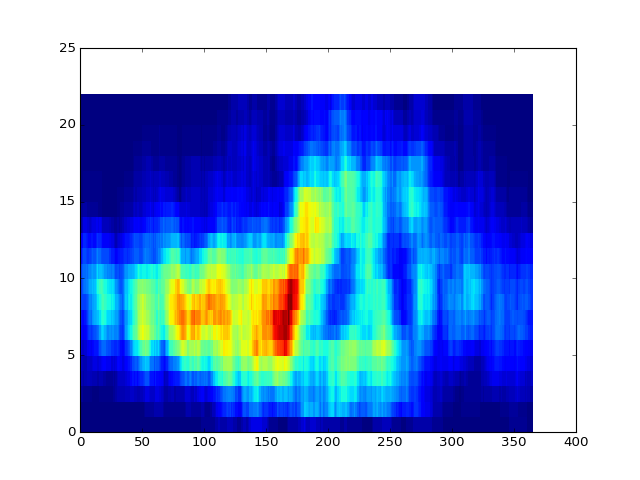

In [12]:
fig1, ax1=plt.subplots()
ax1.pcolormesh(lats_hov_smth[4].T)

In [25]:
#SAVE AS NETCDF FILE
savefile = "RDA_hov_periods"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
hovname = ferretpath + savefile + ".nc"

#check if file exists and if so destroy it!
if os.path.isfile(hovname):
    os.remove(hovname)

#create NetCDF file
hovout = nc.Dataset(hovname, "w")

#create dimensions in NetCDF file
days_dim = hovout.createDimension('time', None)
lat_dim = hovout.createDimension('lat', 22)
dim_tuple = ("time","lat")

#use same years as chosen above:
#yr_beg = [1951,1951,1980,1980,1994]
#yr_end = [2007,1979,2007,1993,2007]

for i, (yr_b, yr_e) in enumerate(zip(yr_beg, yr_end)):

    #convoluted line of code below guarantees that 2007 will become '07' and not '7'
    years = str(yr_b-1900) + str("{0:0=2d}".format((yr_e-1900)%100))
    print(years)

    #create variables inside netCDF file
    lat_1_out = hovout.createVariable("lat_1_hov_" + years, 'f8', dim_tuple)
    lat_2_out = hovout.createVariable("lat_2_hov_" + years, 'f8', dim_tuple)
    lat_out = hovout.createVariable("lat_hov_" + years, 'f8', dim_tuple)

    lat_1_smth_out = hovout.createVariable("lat_1_hov_smth_" + years, 'f8', dim_tuple)
    lat_2_smth_out = hovout.createVariable("lat_2_hov_smth_" + years, 'f8', dim_tuple)
    lat_smth_out = hovout.createVariable("lat_hov_smth_" + years, 'f8', dim_tuple)

    lat_1_out[:] = lats_1_hov[i]
    lat_2_out[:] = lats_2_hov[i]
    lat_out[:] = lats_hov[i]

    lat_1_smth_out[:] = lats_1_hov_smth[i]
    lat_2_smth_out[:] = lats_2_hov_smth[i]
    lat_smth_out[:] = lats_hov_smth[i]

hovout.close()

5107
5179
8007
8093
9407


In [21]:
"{0:0=2d}".format(-1)

'-1'

In [20]:
hovout.close()